In [1]:
import numpy as np
from time import time
from utils import *
import mls as md
import fw

# Warehouse

In [2]:
# X: n*p  W: p*m  Y: n*m
# =======================

# default parameters
param = {'n':100, 'm':100, 'p':100, 'r':10, 'nn':1, 'seed':0}

# generate data
data, W = md.generate(**param)

# prepare data
points = mat2point(*data)
dataRDD = sc.parallelize(points, 2).mapPartitions(point2mat)

# Optimization

In [3]:
# parameter
T = 2
lmo = fw.centralize
step = fw.linesearch
nn = 1
# init
U = []
V = []
A = np.array([])
timer = np.zeros(T)
statRDD = dataRDD.map(md.stats).setName("initial").persist()
# iter
for t in range(T):
    u, v = fw.regularize(*lmo(statRDD), nn)
    a = step(rdd = statRDD, u = u, v = v, t = t, ls = md.linesearch)
    timer[t] = time()
    statRDD = fw.update(statRDD, u, v, a, f = md.update)
    statRDD.setName("turn" + str(t)).persist()
    U.append(u)
    V.append(v)
    A = np.append(A, a)

# Evaluation

In [4]:
emprisk = [md.loss(*data)]
eva = [np.linalg.norm(todense(W))]

In [5]:
W0 = LRmatrix([], [], [])
for u, v, a in zip(U, V, A):
    W0 = LRmatrix([a], [u], [v]) + (1 - a) * W0
    emprisk.append(md.loss(*data, W0))
    eva.append(np.linalg.norm(todense(W0 + -W)))
emprisk = [x / emprisk[0] for x in emprisk]
eva = [x / eva[0] for x in eva]

In [6]:
import matplotlib.pyplot as plt
%matplotlib inline

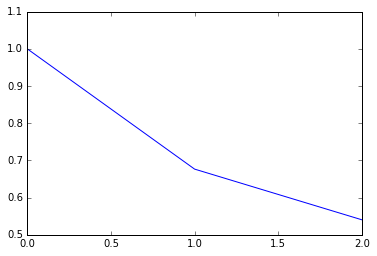

In [7]:
plt.plot(emprisk)

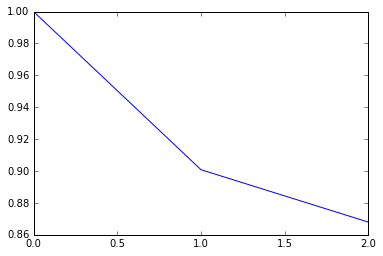

In [8]:
plt.plot(eva)

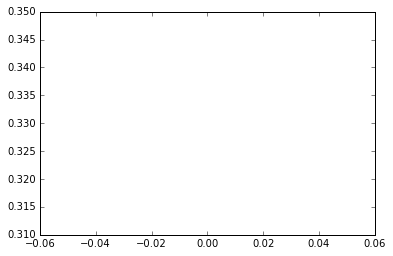

In [9]:
plt.plot(np.diff(timer))

In [13]:
prod(emprisk + eva)

0.2857921340203271